## 環境構築
- GPUインスタンスじゃないと動きません

追記
- そもそもColabはバグってこちらの入力を反映させることができませんでした。
- display_audio()の後にinput()を同じセルで実行したとき、input()できないっぽいです。
    - それさえ出来れば動きます。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

### 音楽生成モジュールのインストール

In [9]:
using_colab = False  # コラボですか？GPUのあるローカルじゃないと動かないと思います。

: 

In [3]:
if using_colab:
    !pip install audiocraft
    !git clone https://github.com/yudaisugiyama/Noimu.git -b dev
    %cd Noimu
else:
    %cd ..

/home/umenty/dev/hackathon/Noimu


In [4]:
!ls

README.md		 launch.sh		      soundAI
Unity			 learning_thread.py	      static
__pycache__		 licenses		      suzuki_test
communication_thread.py  log			      test.py
config.py		 lora-calm-small	      test_calm.py
demo			 open_calm_thread.py	      unity.py
environment.yml		 rl_with_human_preference.py  utils.py


## モデルの生成
- 二つのモデルを生成する（強化学習モデル内で音楽生成モデルも生成される）
    1. 音楽生成モデル
    2. 強化学習モデル

In [5]:
from soundAI.rl_model import RLModel
rl_model = RLModel([["uptempo", "calm"], ["rock", "classic piano", "EDM"]], num_hidden=32, replay_buffer_size=1, learning_rate=0.1, debug=False)

/home/umenty/miniconda3/envs/geek2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import numpy as np
print(rl_model.all_prompts)

['uptempo rock.', 'uptempo classic piano.', 'uptempo EDM.', 'calm rock.', 'calm classic piano.', 'calm EDM.']


## 学習用関数を定義

In [7]:
from audiocraft.utils.notebook import display_audio
tau = 0.8

def calc_probs(model: RLModel, tau: float) -> list[float]:
    # 各音楽の評価値を求める
    input_outputs = model.network.calc_all_qvalues()
    outputs = [-(i_o[1] - 30).item() for i_o in input_outputs]

    # ソフトマックス選択の確率を求める
    sum_exp_values = sum([np.exp(v/tau) for v in outputs])   # softmax選択の分母の計算
    p = [np.exp(v/tau)/sum_exp_values for v in outputs]      # 確率分布の生成

    return p

def feedback_loop():
    print("現在の音楽選択確率はグラフのようになります。")
    probs = calc_probs(rl_model, tau)
    fig, ax = plt.subplots()  # グラフを出す
    ax.pie(probs, labels=rl_model.all_prompts, autopct="%1.2f%%")
    plt.show()

    prompt, wav = rl_model.choose_music(duration=2, tau=tau)
    print(f"プロンプト'{prompt}'を使用して音楽を生成しました。")
    display_audio(wav, sample_rate=32000)

    elapsed_time = float(input("この音楽をアラームにしたら何秒で起きれそうですか？時間をご記入ください。"))

    print("学習します。")
    rl_model.add_latest_prompt(prompt)
    rl_model.add_feedback(elapsed_time)
    rl_model.learn()

現在の音楽選択確率はグラフのようになります。


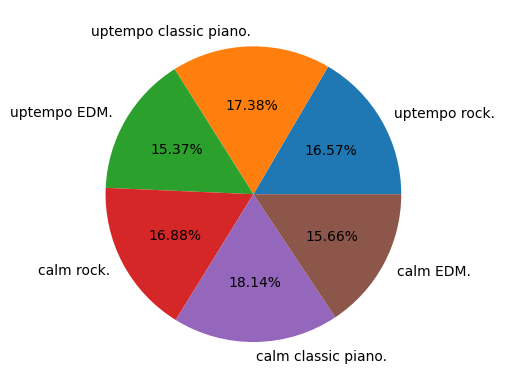

プロンプト'calm classic piano.'を使用して音楽を生成しました。


学習します。
現在の音楽選択確率はグラフのようになります。


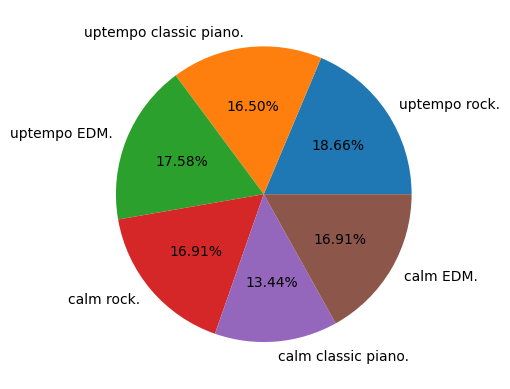

プロンプト'uptempo EDM.'を使用して音楽を生成しました。


学習します。
現在の音楽選択確率はグラフのようになります。


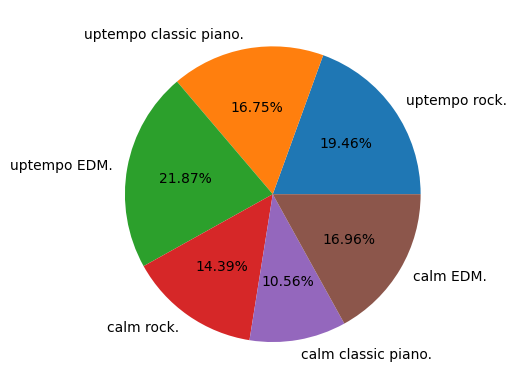

プロンプト'uptempo classic piano.'を使用して音楽を生成しました。


学習します。
現在の音楽選択確率はグラフのようになります。


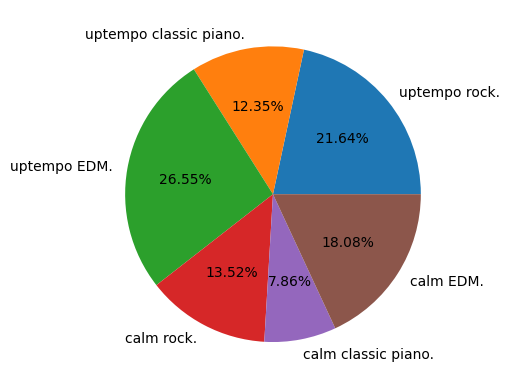

プロンプト'calm EDM.'を使用して音楽を生成しました。


学習します。
現在の音楽選択確率はグラフのようになります。


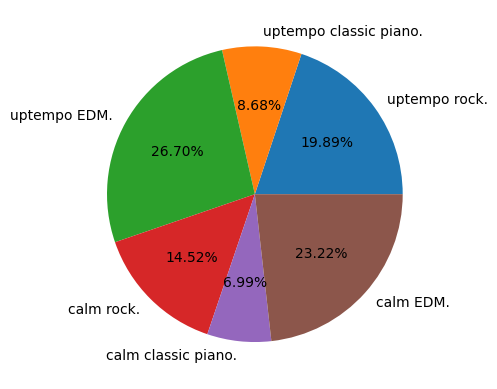

プロンプト'uptempo EDM.'を使用して音楽を生成しました。


学習します。
現在の音楽選択確率はグラフのようになります。


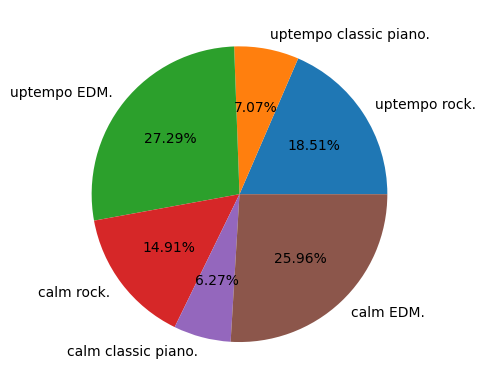

プロンプト'uptempo EDM.'を使用して音楽を生成しました。


学習します。
現在の音楽選択確率はグラフのようになります。


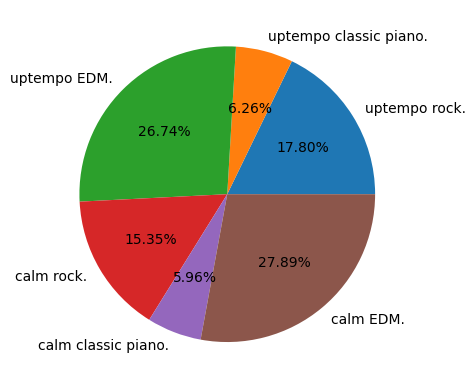

プロンプト'calm EDM.'を使用して音楽を生成しました。


学習します。
現在の音楽選択確率はグラフのようになります。


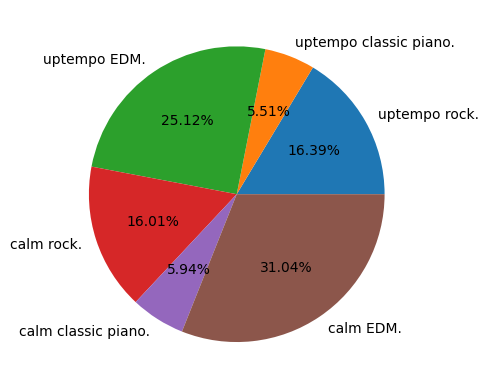

プロンプト'calm rock.'を使用して音楽を生成しました。


ValueError: could not convert string to float: ''

In [8]:
while True:
    feedback_loop()

- 選択確率が変化しました(*^◯^*)